# Optimization Theory and Mathematics for Neural Networks

**Comprehensive lecture-style notes** with rigorous derivations, clear intuition, and applied formulas for a concrete neural-network example (binary classification of points inside/outside the unit circle). All displayed mathematics uses `$$` (no single `$` inline math) and each equation is given as an unbroken block.

---

## Abstract

These notes collect core mathematical foundations and optimization algorithms used when training neural networks. We focus on gradient-based methods (Gradient Descent, Stochastic Gradient Descent, and Adam), derive gradients via backpropagation, and connect theory to a minimal example: a 2→3→1 neural network with ReLU hidden units and a sigmoid output trained with binary cross-entropy.

---

## Table of Contents

1. Notation and problem statement
2. Neural network forward pass (example)
3. Loss: binary cross-entropy
4. Backpropagation: exact derivative computations
5. Gradient Descent (GD): derivation and convergence (convex case)
6. Stochastic Gradient Descent (SGD): variance, momentum, convergence
7. Adam: derivation, bias correction, intuition
8. Practical considerations (learning rates, initialization, stability)
9. Pseudocode and implementation notes
10. References & further reading (suggested)

---

## 1. Notation and problem statement

We consider a neural network parameterized by

$$
\theta = \{W^{(1)}, b^{(1)}, W^{(2)}, b^{(2)}\}.
$$

* Input vectors: $\mathbf{x} \in \mathbb{R}^{2}$ (column vectors of shape \$2\times 1\$).
* Hidden activations (layer 1): 3 neurons with ReLU.
* Output: single neuron with sigmoid activation.
* Dataset of \$m\$ samples: $\{(\mathbf{x}_i, y_i)\}_{i=1}^m$ with labels \$y\_i\in{0,1}\$.

Our goal is to minimize the empirical binary cross-entropy loss:

$$
\mathcal{L}(\theta) = -\frac{1}{m} \sum_{i=1}^m \left[ y_i \log(\hat{y}_i) + (1-y_i) \log(1-\hat{y}_i) \right].
$$

All displayed formulas use double-dollar delimiters and are self-contained.

---

## 2. Neural network forward pass (example)

Forward equations per sample (index \$i\$ suppressed for clarity):

$$
\mathbf{z}^{(1)} = W^{(1)} \mathbf{x} + b^{(1)}
$$

$$
\mathbf{a}^{(1)} = \mathrm{ReLU}(\mathbf{z}^{(1)}) = \max(\mathbf{0}, \mathbf{z}^{(1)})
$$

$$
z^{(2)} = W^{(2)} \mathbf{a}^{(1)} + b^{(2)}
$$

$$
\hat{y} = \sigma(z^{(2)}) = \frac{1}{1 + e^{-z^{(2)}}}.
$$

Shapes: $W^{(1)}\in\mathbb{R}^{3\times 2},\; b^{(1)}\in\mathbb{R}^{3},\; W^{(2)}\in\mathbb{R}^{1\times 3},\; b^{(2)}\in\mathbb{R}.$

---

## 3. Loss: binary cross-entropy (BCE)

Per-sample loss:

$$
\ell(\hat{y}, y) = -\left[ y \log(\hat{y}) + (1-y) \log(1-\hat{y}) \right].
$$

Full-batch empirical loss repeated for clarity:

$$
\mathcal{L}(\theta) = -\frac{1}{m} \sum_{i=1}^m \left[ y_i \log(\hat{y}_i) + (1-y_i) \log(1-\hat{y}_i) \right].
$$

**Numerical stability:** clip predictions so that $\hat{y}_i \in [\varepsilon, 1-\varepsilon]$ with a small $\varepsilon \approx 10^{-15}$ to avoid logarithm of zero.

---

## 4. Backpropagation: exact derivative computations

We derive gradients for the output and hidden layers and show compact batch-form expressions.

### 4.1 Output layer derivatives

Start with the chain of derivatives for a single sample. Using the BCE loss and sigmoid output, compute

$$
\frac{\partial \ell}{\partial \hat{y}} = -\frac{y}{\hat{y}} + \frac{1-y}{1-\hat{y}}.
$$

Sigmoid derivative:

$$
\frac{\partial \hat{y}}{\partial z^{(2)}} = \hat{y}(1-\hat{y}).
$$

Combining the two gives (algebra simplifies to):

$$
\frac{\partial \ell}{\partial z^{(2)}} = \hat{y} - y.
$$

Define the output-layer error (per sample):

$$
\delta^{(2)} := \frac{\partial \ell}{\partial z^{(2)}} = \hat{y} - y.
$$

Gradients w\.r.t. parameters (per-sample):

$$
\frac{\partial \ell}{\partial W^{(2)}} = \delta^{(2)} (\mathbf{a}^{(1)})^T,
\quad
\frac{\partial \ell}{\partial b^{(2)}} = \delta^{(2)}.
$$

Batch gradients (average over \$m\$):

$$
\frac{\partial \mathcal{L}}{\partial W^{(2)}} = \frac{1}{m} \sum_{i=1}^m \delta^{(2)}_i (\mathbf{a}^{(1)}_i)^T,
\quad
\frac{\partial \mathcal{L}}{\partial b^{(2)}} = \frac{1}{m} \sum_{i=1}^m \delta^{(2)}_i.
$$

### 4.2 Hidden layer derivatives (ReLU)

Backpropagate the error through the linear mapping and the activation derivative. For a single sample,

$$
\frac{\partial \ell}{\partial \mathbf{z}^{(1)}} = (W^{(2)})^T \delta^{(2)} \odot \sigma'(\mathbf{z}^{(1)}),
$$

where the ReLU derivative is the elementwise function

$$
\sigma'(z) =
\begin{cases}
1 & z > 0, \\
0 & z \le 0.
\end{cases}
$$

Define

$$
\delta^{(1)} := (W^{(2)})^T \delta^{(2)} \odot \sigma'(\mathbf{z}^{(1)}).
$$

Gradients (per-sample):

$$
\frac{\partial \ell}{\partial W^{(1)}} = \delta^{(1)} (\mathbf{x})^T,
\quad
\frac{\partial \ell}{\partial b^{(1)}} = \delta^{(1)}.
$$

Batch-averaged gradients:

$$
\frac{\partial \mathcal{L}}{\partial W^{(1)}} = \frac{1}{m} \sum_{i=1}^m \delta^{(1)}_i (\mathbf{x}_i)^T,
\quad
\frac{\partial \mathcal{L}}{\partial b^{(1)}} = \frac{1}{m} \sum_{i=1}^m \delta^{(1)}_i.
$$

### 4.3 Complexity of one backward pass

If \$p\$ denotes the total number of parameters, a full-batch forward+backward costs \$O(mp)\$ arithmetic operations; a mini-batch of size \$b\$ costs \$O(bp)\$.

---

## 5. Gradient Descent (GD): derivation and convergence (convex case)

### 5.1 Update rule and intuition

Full-batch gradient descent updates every parameter using the full empirical gradient:

$$
\theta^{(t+1)} = \theta^{(t)} - \eta \nabla_\theta \mathcal{L}(\theta^{(t)}),
$$

where \$\eta>0\$ is the learning rate.

Intuitively this moves parameters in the direction of steepest descent. The step size \$\eta\$ controls stability vs. speed.

### 5.2 First-order Taylor argument

For a candidate step \$g\$, the Taylor expansion gives

$$
\mathcal{L}(\theta - \eta g) \approx \mathcal{L}(\theta) - \eta g^T \nabla_\theta \mathcal{L}(\theta) + \frac{\eta^2}{2} g^T H g,
$$

with \$H\$ the Hessian. Choosing \$g = \nabla\_\theta \mathcal{L}(\theta)\$ minimizes the first-order term; for sufficiently small \$\eta\$ the quadratic term is negligible and the loss decreases approximately by \$\eta |\nabla\_\theta \mathcal{L}|^2\$.

### 5.3 Convergence (convex, L-smooth)

If \$\mathcal{L}\$ is convex and \$L\$-smooth (i.e., the gradient is Lipschitz: \$|\nabla \mathcal{L}(x)-\nabla \mathcal{L}(y)| \le L |x-y|\$), gradient descent with a constant step size \$\eta \le 1/L\$ yields a sublinear convergence rate:

$$
\mathcal{L}(\theta^{(T)}) - \mathcal{L}^* \le \frac{\|\theta^{(0)} - \theta^*\|^2}{2\eta T}.
$$

This shows \$O(1/T)\$ convergence in function value. For strongly convex objectives (with parameter \$\mu>0\$) the rate becomes linear (geometric):

$$
\mathcal{L}(\theta^{(t)}) - \mathcal{L}^* \le \left(1-\eta \mu\right)^t (\mathcal{L}(\theta^{(0)}) - \mathcal{L}^*).
$$

### 5.4 Non-convex setting

Neural network losses are non-convex. GD may converge to local minima or saddle points. Practical remedies include random initialization, small batches (SGD), momentum, and parameter regularization.

---

## 6. Stochastic Gradient Descent (SGD)

SGD reduces per-step cost by using an unbiased estimator of the full gradient computed on a single sample or mini-batch.

### 6.1 Definition and unbiasedness

For a mini-batch \$B\_t\$ of size \$b\$, the stochastic gradient is

$$
g_t = \frac{1}{b} \sum_{i\in B_t} \nabla_\theta \ell(f(\mathbf{x}_i;\theta^{(t)}), y_i).
$$

Unbiasedness:

$$
\mathbb{E}[g_t] = \nabla_\theta \mathcal{L}(\theta^{(t)}).
$$

Variance (non-zero):

$$
\mathrm{Var}(g_t) = \mathbb{E}[\|g_t - \nabla \mathcal{L}\|^2] > 0.
$$

The variance injects noise which can help escape saddle points but can cause oscillation near minima.

### 6.2 SGD update

$$
\theta^{(t+1)} = \theta^{(t)} - \eta g_t.
$$

### 6.3 Convergence guarantees (high-level)

For strongly convex objectives with bounded gradient variance \$\sigma^2\$, with a properly diminishing step size (e.g., \$\eta\_t = c/t\$) SGD satisfies:

$$
\mathbb{E}[\mathcal{L}(\theta^{(T)}) - \mathcal{L}^*] \le O\left(\frac{1}{T}\right) + O(\eta \sigma^2).
$$

In non-convex problems SGD typically converges to a stationary point (where \$\nabla \mathcal{L} \approx 0\$) under mild conditions.

### 6.4 Momentum

To reduce oscillations and accelerate through shallow valleys, momentum accumulates a velocity vector. Two common variants:

**Heavy-ball momentum**:

$$
v^{(t+1)} = \beta v^{(t)} + g_t,
\quad
\theta^{(t+1)} = \theta^{(t)} - \eta v^{(t+1)}.
$$

**Exponential moving average (practical form)**:

$$
v^{(t+1)} = \beta v^{(t)} + (1-\beta) g_t,
\quad
\theta^{(t+1)} = \theta^{(t)} - \eta v^{(t+1)}.
$$

Typical \$\beta \approx 0.9\$.

---

## 7. Adam (Adaptive Moment Estimation)

Adam combines momentum-like first-moment estimates with adaptive per-parameter scaling via second moments.

### 7.1 Algorithmic definitions

Given gradient \$g\_t = \nabla\_\theta \mathcal{L}(\theta^{(t)})\$, Adam maintains:

First moment (biased):

$$
m_t = \beta_1 m_{t-1} + (1-\beta_1) g_t.
$$

Second moment (biased, elementwise squares):

$$
v_t = \beta_2 v_{t-1} + (1-\beta_2) (g_t \odot g_t).
$$

Bias-corrected estimates:

$$
\hat{m}_t = \frac{m_t}{1-\beta_1^t},
\quad
\hat{v}_t = \frac{v_t}{1-\beta_2^t}.
$$

Parameter update (elementwise):

$$
\theta^{(t+1)} = \theta^{(t)} - \eta \frac{\hat{m}_t}{\sqrt{\hat{v}_t} + \epsilon}.
$$

Typical defaults: $\eta=0.001,\;\beta_1=0.9,\;\beta_2=0.999,\;\epsilon=10^{-8}.$

### 7.2 Intuition and connections

* \$\hat{m}\_t\$ behaves like momentum (smoothed gradient direction).
* \$\sqrt{\hat{v}\_t}\$ rescales steps by recent gradient magnitudes (RMS-style), preventing too-large steps on parameters with large gradient variance.
* The bias correction counters the zero initialization of \$m\_0,v\_0\$ so the early updates are not unduly small.

### 7.3 Convergence notes

Adam often converges faster in practice on deep networks, but theoretical convergence is subtler: certain pathological choices of hyperparameters can prevent convergence; variants like AMSGrad were proposed to repair worst-case guarantees. In practice Adam is robust and widely used.

---

## 8. Practical considerations and recipes

### 8.1 Learning rate choices and schedules

* Default Adam: $\eta=0.001$ often works well. SGD often needs more tuning (e.g., $\eta \in [0.01, 0.1]$ for simple nets).

Common schedules:

**Step decay:** reduce at milestones.

$$
\eta_t = \eta_0 \times \gamma^{\lfloor t/T_{\text{step}} \rfloor}.
$$

**Inverse time decay:**

$$
\eta_t = \frac{\eta_0}{1 + \lambda t}.
$$

**Cosine annealing:**

$$
\eta_t = \eta_{\min} + \tfrac{1}{2}(\eta_{\max}-\eta_{\min})\left(1 + \cos\left(\pi \frac{t}{T}\right)\right).
$$

### 8.2 Weight initialization

* **Xavier / Glorot (for tanh/linear activations):**

$$
\mathrm{Var}(W) = \frac{2}{\text{fan\_in} + \text{fan\_out}}.
$$

* **He / Kaiming (for ReLU):**

$$
\mathrm{Var}(W) = \frac{2}{\text{fan\_in}}.
$$

Careful initialization prevents early saturation or exploding signals.

### 8.3 Vanishing and exploding gradients

* **Vanishing gradients:** activations with small derivatives (sigmoid, tanh) or poor initialization cause gradients to shrink exponentially across layers. ReLU mitigates but can create dead units.
* **Exploding gradients:** uncontrolled growth of gradients; fix with gradient clipping (clip-by-norm) or smaller initial weights.

**Gradient clipping by norm:**

$$
\text{if } \|g\|_2 > C \text{ then } g \leftarrow C \frac{g}{\|g\|_2}.
$$

### 8.4 Regularization and stability

* **Batch Normalization** stabilizes distributions of layer inputs and often allows larger learning rates.
* **Weight decay (L2 regularization):** adds $\frac{\lambda}{2}\|\theta\|^2$ to the loss which results in shrinkage of parameters on every step.

### 8.5 Numerical stability tips

* Clip probabilities in BCE to $[\varepsilon, 1-\varepsilon]$.
* Add small $\epsilon$ in denominators (Adam uses $\epsilon$ to avoid division by zero).

---

## 9. Pseudocode and implementation notes

Below are compact pseudocode blocks illustrating a single training iteration (forward, backward, update) for GD/SGD/Adam. These are for clarity — translate into your favorite framework.

### 9.1 Single-step (vectorized mini-batch) pseudocode

```
# Pseudocode (conceptual)
# Inputs: batch X (shape b x 2), labels y (shape b)
# Parameters: W1, b1, W2, b2

# Forward
Z1 = W1 @ X.T + b1[:, None]
A1 = relu(Z1)
Z2 = W2 @ A1 + b2
Yhat = sigmoid(Z2)

# Loss
L = -mean( y*log(Yhat) + (1-y)*log(1-Yhat) )

# Backward (vectorized)
Delta2 = Yhat - y  # shape (1, b)
dW2 = (1/b) * Delta2 @ A1.T
db2 = (1/b) * sum(Delta2, axis=1)

Delta1 = (W2.T @ Delta2) * relu_prime(Z1)
dW1 = (1/b) * Delta1 @ X
db1 = (1/b) * sum(Delta1, axis=1)

# Update (example: SGD)
W1 -= eta * dW1
b1 -= eta * db1
W2 -= eta * dW2
b2 -= eta * db2
```

### 9.2 Adam-specific update (per-parameter arrays)

```
# m, v: running first and second moments (same shape as params)
m = beta1 * m + (1-beta1) * grad
v = beta2 * v + (1-beta2) * (grad * grad)
m_hat = m / (1 - beta1**t)
v_hat = v / (1 - beta2**t)
param -= eta * m_hat / (sqrt(v_hat) + eps)
```

---

## 10. Example: practical walkthrough (circle classifier)

* Initialize parameters with He initialization for layers using ReLU.
* Use mini-batches (b=32) and Adam with default hyperparameters as a robust baseline.
* Monitor training and validation loss; if validation loss plateaus reduce learning rate (step decay or cosine anneal).
* If many dead ReLU units appear (large fraction of zeros in A1), consider Leaky ReLU or smaller initial weights.

---

## 11. Summary and closing insights

* **GD**: deterministic, stable per-step but expensive for large datasets. Converges at \$O(1/T)\$ for convex \$L\$-smooth objectives.
* **SGD**: cheap per-step, noisy but often better in non-convex settings due to exploratory noise. Momentum improves stability and speed.
* **Adam**: adaptive and momentum combined; often fastest to a good solution in deep nets but requires awareness of theoretical caveats.

Understanding the mathematics of gradients and their propagation (backpropagation) plus careful hyperparameter and initialization choices is the practical path to effective neural network training.

---



Epoch 0, Loss: 0.6932
Epoch 100, Loss: 0.6319
Epoch 200, Loss: 0.6313
Epoch 300, Loss: 0.6312
Epoch 400, Loss: 0.6309
Epoch 500, Loss: 0.6301
Epoch 600, Loss: 0.6274
Epoch 700, Loss: 0.6194
Epoch 800, Loss: 0.6016
Epoch 900, Loss: 0.5734
Training accuracy: 0.6740


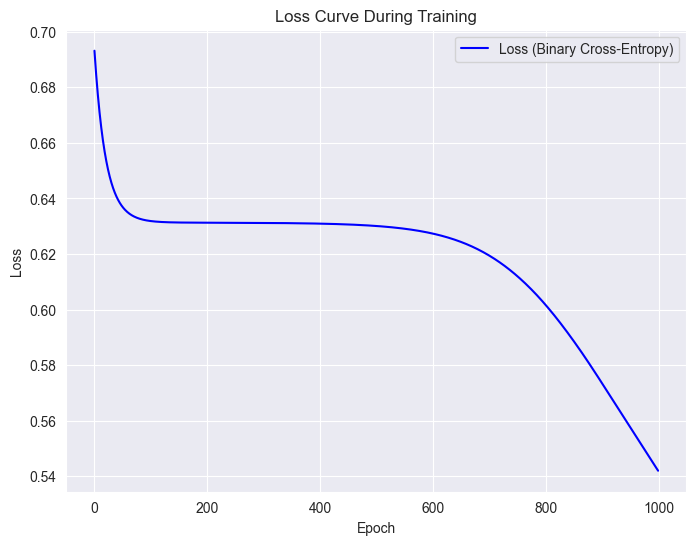

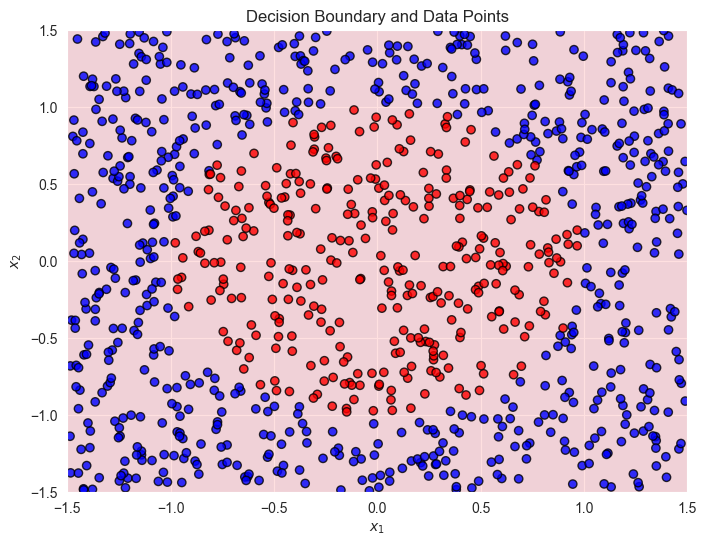

In [3]:
import numpy as np
import matplotlib.pyplot as plt


# Activation functions and their derivatives
def relu(x):
    return np.maximum(0, x)


def relu_derivative(x):
    return np.where(x > 0, 1, 0)


def sigmoid(x):
    return 1 / (1 + np.exp(-np.clip(x, -500, 500)))


def sigmoid_derivative(x):
    s = sigmoid(x)
    return s * (1 - s)


# Binary cross-entropy loss
def binary_cross_entropy(y_true, y_pred):
    y_pred = np.clip(y_pred, 1e-15, 1 - 1e-15)
    return -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))


class NeuralNetwork:
    def __init__(self):
        np.random.seed(42)
        self.w1 = np.random.randn(3, 2) * 0.01  # 3x2 weights (input to hidden)
        self.b1 = np.zeros((3, 1))  # 3x1 biases (hidden)
        self.w2 = np.random.randn(1, 3) * 0.01  # 1x3 weights (hidden to output)
        self.b2 = np.zeros((1, 1))  # 1x1 bias (output)

    def forward(self, X):
        self.z1 = np.dot(self.w1, X) + self.b1
        self.a1 = relu(self.z1)
        self.z2 = np.dot(self.w2, self.a1) + self.b2
        self.a2 = sigmoid(self.z2)
        return self.a2

    def backward(self, X, y, y_pred, learning_rate=0.1):
        m = X.shape[1]
        delta2 = y_pred - y
        dw2 = np.dot(delta2, self.a1.T) / m
        db2 = np.sum(delta2, axis=1, keepdims=True) / m
        delta1 = np.dot(self.w2.T, delta2) * relu_derivative(self.z1)
        dw1 = np.dot(delta1, X.T) / m
        db1 = np.sum(delta1, axis=1, keepdims=True) / m
        # Gradient Descent
        self.w1 -= learning_rate * dw1
        self.b1 -= learning_rate * db1
        self.w2 -= learning_rate * dw2
        self.b2 -= learning_rate * db2

    def train(self, X, y, epochs=1000, learning_rate=0.1):
        losses = []
        for epoch in range(epochs):
            y_pred = self.forward(X)
            loss = binary_cross_entropy(y, y_pred)
            losses.append(loss)
            self.backward(X, y, y_pred, learning_rate)
            if epoch % 100 == 0:
                print(f"Epoch {epoch}, Loss: {loss:.4f}")
        return losses


def generate_data(n_samples=1000):
    np.random.seed(42)
    X = np.random.uniform(-1.5, 1.5, (2, n_samples))
    y = np.sum(X ** 2, axis=0) <= 1
    y = y.astype(float).reshape(1, n_samples)
    return X, y


def plot_loss_curve(losses):
    plt.figure(figsize=(8, 6))
    plt.plot(losses, label='Loss (Binary Cross-Entropy)', color='blue')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Curve During Training')
    plt.legend()
    plt.grid(True)
    plt.show()


def plot_decision_boundary(nn, X, y):
    # Create a grid of points
    x_min, x_max = -1.5, 1.5
    y_min, y_max = -1.5, 1.5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
    grid = np.c_[xx.ravel(), yy.ravel()].T  # Shape: (2, 10000)

    # Predict on grid points
    Z = nn.forward(grid)
    Z = (Z > 0.5).astype(float).reshape(xx.shape)

    # Plot
    plt.figure(figsize=(8, 6))
    # Decision boundary
    plt.contourf(xx, yy, Z, levels=[-1, 0, 1], colors=['#FF9999', '#99FF99'], alpha=0.3)
    plt.contour(xx, yy, Z, levels=[0.5], colors='black', linestyles='--')
    # Data points
    plt.scatter(X[0, :], X[1, :], c=y[0, :], cmap='bwr', edgecolors='k', alpha=0.8)
    plt.xlabel('$x_1$')
    plt.ylabel('$x_2$')
    plt.title('Decision Boundary and Data Points')
    plt.show()


if __name__ == "__main__":
    X, y = generate_data(1000)
    nn = NeuralNetwork()
    losses = nn.train(X, y, epochs=1000, learning_rate=0.1)
    y_pred = nn.forward(X)
    accuracy = np.mean((y_pred > 0.5).astype(float) == y)
    print(f"Training accuracy: {accuracy:.4f}")

    plot_loss_curve(losses)
    plot_decision_boundary(nn, X, y)

In [2]:

n = np.zeros((3, 1))
n
x = np.random.randn(1, 3) * 0.01
x

array([[ 0.0054256 , -0.00463418, -0.0046573 ]])